In [1]:
import glob
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from skimage.io import imread
import numpy as np
import torch.cuda.amp as amp
import torchvision.transforms as transforms
from collections import OrderedDict
import pandas
import matplotlib.pyplot as plt
from PIL import Image

# Import the optimizer
import torch.optim as optim

# Import the writer
from torch.utils.tensorboard import SummaryWriter

# Counter for the imbalance
from collections import Counter
import random

**Il dataset: LoveDA**

[LoveDA: A Remote Sensing Land-Cover Dataset for Domain Adaptive Semantic Segmentation
](https://arxiv.org/abs/2110.08733)

LoveDA consiste di 5987 immagini HSR con 166768 oggetti annotati provenienti da tre diverse città. Rispetto ai dataset esistenti, il dataset LoveDA comprende due domini (urbano e rurale), il che comporta notevoli sfide dovute a:

*   oggetti multi-scala;
*   background complessi;
*   distribuzioni di classi non uniformi

In particolare, il dataset copre 7 differenti classi:

1.   Background
2.   Building
3. Road
4. Water
5. Barren
6. Forest
7. Agricolture


In questo progetto, utilizzeremo il **dominio urbano** per trainare una rete neurale in grado di segmentare le diverse categorie.

Se !gdown non funziona, scaricare il file al link https://drive.google.com/file/d/1zLotJN3vHJ8S4WjJ0_PkG26EU22rY1df/view?usp=sharing caricarlo sul proprio drive e mettere l'id come nella scorsa esercitazione


In [2]:
!gdown "1gdwjDHxpbbW6AtzRgbmeVskKc-wAVqgl"


if not os.path.exists('loveDA.zip'):
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  from datetime import datetime as dt

  #1.Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print(dt.now())


  idfile="1zLotJN3vHJ8S4WjJ0_PkG26EU22rY1df"
  downloaded = drive.CreateFile({'id': idfile})
  downloaded.GetContentFile('loveDA.zip')

!unzip loveDA.zip




Downloading...
From (original): https://drive.google.com/uc?id=1gdwjDHxpbbW6AtzRgbmeVskKc-wAVqgl
From (redirected): https://drive.google.com/uc?id=1gdwjDHxpbbW6AtzRgbmeVskKc-wAVqgl&confirm=t&uuid=ad268196-8369-47e1-90f0-fd99d34fbe06
To: /content/loveDA.zip
100% 2.93G/2.93G [00:48<00:00, 60.4MB/s]
Archive:  loveDA.zip
   creating: Train/
   creating: Train/Urban/
   creating: Train/Urban/images_png/
  inflating: Train/Urban/images_png/1366.png  
  inflating: Train/Urban/images_png/1367.png  
 extracting: Train/Urban/images_png/1368.png  
 extracting: Train/Urban/images_png/1369.png  
  inflating: Train/Urban/images_png/1370.png  
  inflating: Train/Urban/images_png/1371.png  
  inflating: Train/Urban/images_png/1372.png  
 extracting: Train/Urban/images_png/1373.png  
 extracting: Train/Urban/images_png/1374.png  
  inflating: Train/Urban/images_png/1375.png  
  inflating: Train/Urban/images_png/1376.png  
 extracting: Train/Urban/images_png/1377.png  
 extracting: Train/Urban/images_pn

**Il modello: BiseNet**

[BiseNet: Bilateral Segmentation Network for Real-time Semantic Segmentation](https://arxiv.org/abs/1808.00897)

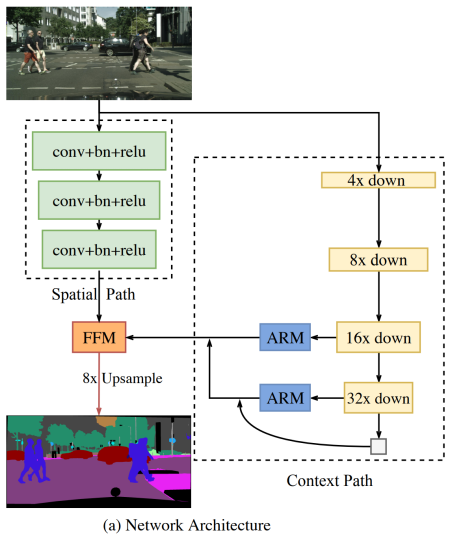

La segmentazione semantica richiede sia una profonda conoscenza spaziale sia un receptive field di dimensioni sufficienti. Tuttavia, gli approcci moderni di solito compromettono la risoluzione spaziale per ottenere una rapida inferenza, causando scarse prestazioni della rete. BiseNet affronta questo problema disegnando una rete con due path:

1.   **Spatial Path**: usa uno stride ridotto per preservare le informazioni spaziali e generare feature ad alta risoluzione.
2.   **Context Path**: usa una strategia di rapido downsampling per ottenere un receptive field sufficientemente elevato da catturare le informazioni globali dell'immagine.

Oltre a questi due path, BiseNet introduce un nuovo modulo di fusione per combinare le fatures estratte dallo Spatial Path e dal Context Path in modo efficiente. L'architettura proposta consente di raggiungere un giusto equilibrio tra velocità e performance.

Clonare la seguente repository per ottenere il codice del modello:

In [ ]:
!git clone https://github.com/Gabrysse/MLDL2024_project1.git

# **STEP 1**
Creare la classe Dataset, la quale si occuperà di accedere a un sample di dati e processarlo.
Ogni classe Dataset personalizzata deve implementare tre funzioni: __init__, __len__ e __getitem__.


1.   La funzione __init__ viene eseguita *una* volta, quando si istanzia l'oggetto Dataset. All'interno di questa funzione, si inizializzano le informazioni necessarie ad accedere e caricare le immagini (e.g. la cartella contenente le immagini, il file delle annotazioni, eventuali trasformazioni...).
2.   La funzione __len__ restituisce il numero di sample del nostro set di dati.
3. La funzione __getitem__ carica e restituisce un sample dal dataset all'indice idx indicato. In base all'indice, si identifica la posizione dell'immagine e della label nelle corrispondenti cartelle. Una volta caricate, vengono chiamate le eventuali funzioni di trasformazione. Infine, l'immagine del tensore e l'etichetta corrispondente vengono restituite in una tupla.




In [5]:
import random
import torchvision.transforms.functional as F

def random_crop_transform_reinsert_with_labels(image_tensor, label_array, crop_size=(512, 512)):
    """
    Randomly crop a patch from an image (PyTorch tensor) and its corresponding label (NumPy array),
    apply the same transformations, and reinsert the transformed patch back into both.

    Args:
        image_tensor (torch.Tensor): Input image tensor of shape (C, H, W).
        label_array (numpy.ndarray): Input label array of shape (H, W).
        crop_size (tuple): Desired size of the crop (height, width).

    Returns:
        torch.Tensor: The original image with the transformed patch reinserted.
        numpy.ndarray: The original label with the transformed patch reinserted.
    """
    # Get image and label dimensions
    _, height, width = image_tensor.shape
    crop_height, crop_width = crop_size

    # Ensure crop size is not larger than the image dimensions
    if crop_height > height or crop_width > width:
        raise ValueError("Crop size must be smaller than the image dimensions.")

    # Randomly choose the top-left corner for the crop
    top = random.randint(0, height - crop_height)
    left = random.randint(0, width - crop_width)

    # Crop the image and label
    cropped_image_patch = F.crop(image_tensor, top, left, crop_height, crop_width)
    cropped_label_patch = label_array[top:top + crop_height, left:left + crop_width]

    # Convert label patch to PyTorch tensor for transformations
    cropped_label_patch = torch.from_numpy(cropped_label_patch)

    # Randomly apply horizontal flip
    if random.random() < 0.5:
        cropped_image_patch = F.hflip(cropped_image_patch)
        cropped_label_patch = F.hflip(cropped_label_patch)

    # Randomly apply vertical flip
    if random.random() < 0.5:
        cropped_image_patch = F.vflip(cropped_image_patch)
        cropped_label_patch = F.vflip(cropped_label_patch)


    # Convert the transformed label patch back to NumPy array
    cropped_label_patch = cropped_label_patch.numpy()

    # Reinsert the transformed patches back into the original image and label
    transformed_image = image_tensor.clone()  # Clone to avoid modifying the original
    transformed_label = label_array.copy()    # Copy to avoid modifying the original

    transformed_image[:, top:top + crop_height, left:left + crop_width] = cropped_image_patch
    transformed_label[top:top + crop_height, left:left + crop_width] = cropped_label_patch

    return transformed_image, transformed_label

In [3]:
  #change to True if you want to data augment
class LoveDA(Dataset):
    def __init__(self, image_dir, mask_dir,augment):
        self.rgb_filepath_list = []
        self.cls_filepath_list= []
        rgb_filepath_list = glob.glob(os.path.join(image_dir, '*.png'))

        print('%s -- Dataset images: %d' % (os.path.dirname(image_dir), len(rgb_filepath_list)))
        rgb_filename_list = [os.path.split(fp)[-1] for fp in rgb_filepath_list]
        cls_filepath_list = []
        for fname in rgb_filename_list:
          cls_filepath_list.append(os.path.join(mask_dir, fname))
        self.rgb_filepath_list += rgb_filepath_list
        self.cls_filepath_list += cls_filepath_list
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        self.augment=augment


    def __getitem__(self, idx):
        image = imread(self.rgb_filepath_list[idx])
        image = self.transforms(image)
        mask = imread(self.cls_filepath_list[idx]).astype(np.int64) - 1
        if self.augment:
          image,mask=random_crop_transform_reinsert_with_labels(image,mask)
        return image, mask

    def __len__(self):
        return len(self.rgb_filepath_list)

    def __path__(self,indice):
      return self.rgb_filepath_list[indice],self.cls_filepath_list[indice]

In [4]:
train_dataset = LoveDA(image_dir = "../content/Train/Urban/images_png", mask_dir = "../content/Train/Urban/masks_png",augment=False)
val_dataset   = LoveDA(image_dir   = "../content/Val/Urban/images_png", mask_dir = "../content/Val/Urban/masks_png",augment=False)


../content/Train/Urban -- Dataset images: 1156
../content/Val/Urban -- Dataset images: 677


**VISUALIZZAZIONE DEI DATI**

L'obiettivo è visualizzare le immagini e le corrispondenti semantic label a partire dal dataset di segmentazione che avete costruito, per comprendere la relazione tra i dati ed annotazioni.

* *show_image()*: per visualizzare un'immagine del dataset.
* *show_label()*: per visualizzare la corrispondente semantic label.

In [9]:
LABEL_MAP = OrderedDict(
  Background=0,
  Building=1,
  Road=2,
  Water=3,
  Barren=4,
  Forest=5,
  Agricultural=6
  )

COLOR_MAP = OrderedDict(
  Background=(255, 255, 255),
  Building=(255, 0, 0),
  Road=(255, 255, 0),
  Water=(0, 0, 255),
  Barren=(159, 129, 183),
  Forest=(0, 255, 0),
  Agricultural=(255, 195, 128),
  )

def colour_code_segmentation(label):
  '''
  Given a 1-channel label, it retrieves the corresponding colour code to create the 3-channel mask.
  # Returns
      Colour coded image for segmentation visualization
  '''
  w = label.shape[0]
  h = label.shape[1]
  # Create a tensor x filled with 0
  x = np.zeros([w,h,3])
  for i in range(0, w):
        for j in range(0, h):
            # For each label, retrieve the corresponding RGB colour
            if label[i,j] != -1:
                x[i, j, :] = COLOR_MAP[list(LABEL_MAP.keys())[int(label[i, j]) ]]
  return x

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],  std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),])

In [ ]:
# Helper function for inline image display
def show_image(img, transform=None, one_channel=False):
    img = transform(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_label(img):
    npimg = colour_code_segmentation(img)
    npimg = npimg.astype(int)
    plt.imshow(npimg)
    plt.show()

In [ ]:
def show_image_with_label(img, label, transform=None):
  if transform:
    img = transform(img)

  npimg = img.numpy()
  npimg = np.transpose(npimg, (1, 2, 0))
  np_label = colour_code_segmentation(label)
  np_label = np_label.astype(int)

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(npimg)
  axs[0].axis("off")
  axs[0].set_title("Image")
  axs[1].imshow(np_label)
  axs[1].axis("off")
  axs[1].set_title("Label")
  plt.tight_layout()
  plt.show()

Creiamo un iterabile per scorrere il training/validation dataset:

In [ ]:
dataiter = iter(train_dataset)

In [ ]:
for i in range(20):
  images, labels = next(dataiter)
  show_image_with_label(images, labels, transform=invTrans)
  images,labels=random_crop_transform_reinsert_with_labels(images,labels)
  show_image_with_label(images, labels, transform=invTrans)

In [ ]:
labels[200][1]

0

In [ ]:
images, labels = next(dataiter)

In [ ]:
print(images.shape)
print(labels.shape)

torch.Size([3, 1024, 1024])
(1024, 1024)


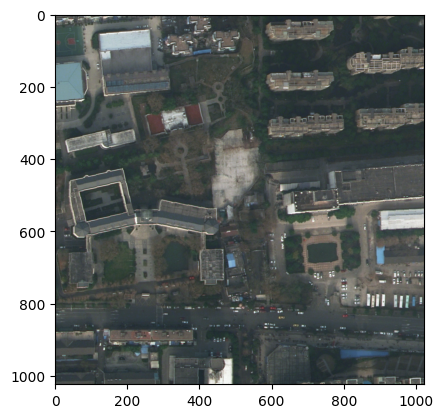

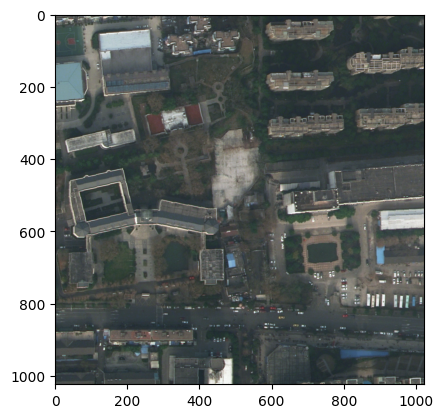

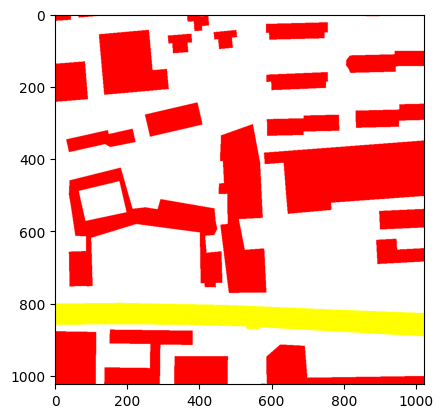

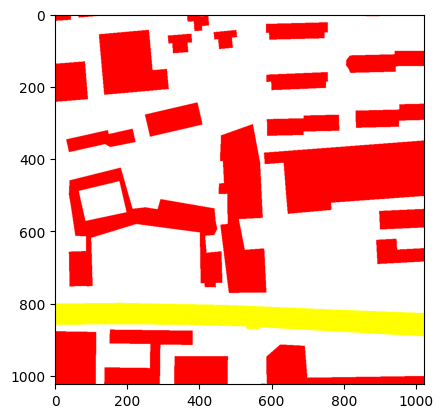

In [ ]:
img_trans,lab_trans=random_crop_transform_reinsert_with_labels(images,labels)

show_image(images, transform=invTrans)
show_image(img_trans, transform=invTrans)

show_label(labels)
show_label(lab_trans)

Visualizziamo l'immagine:

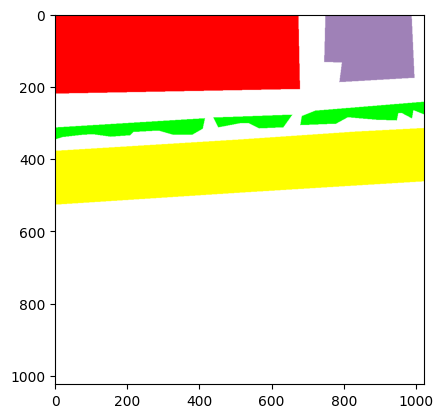

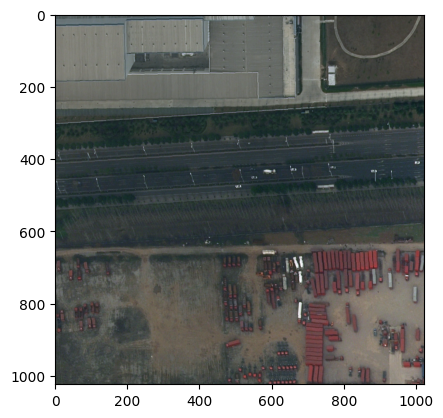

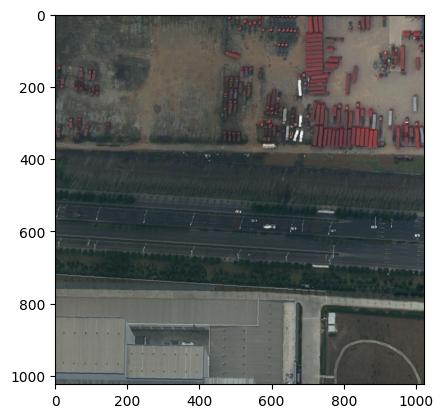

<class 'torch.Tensor'>


In [ ]:
hflip_t = transforms.RandomVerticalFlip(p = 1)
images, labels = train_dataset[150]
show_label(labels)
show_image(images, transform=invTrans)
show_image(hflip_t(images), transform=invTrans)
images=hflip_t(images)
print(type(images))

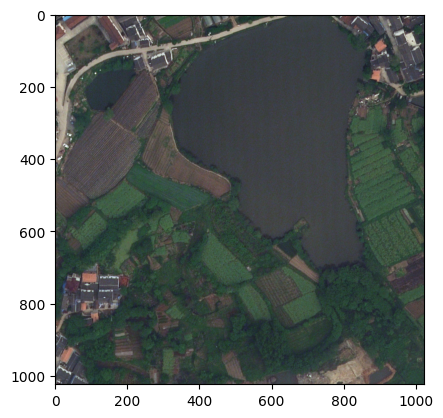

In [ ]:
show_image(images, transform=invTrans)

Visualizziamo la label corrispondente:

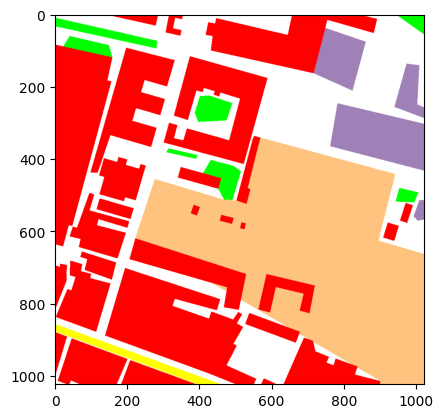

In [ ]:
show_label(labels)

**DATA IMBALANCE**

Il data imbalance è un problema comune nei dataset di segmentazione, dove alcune classi sono rappresentate da molte più istanze rispetto ad altre. Questo squilibrio può causare difficoltà nel training di modelli, che tendono a favorire le classi più rappresentate a discapito di quelle meno frequenti. Di conseguenza, il modello potrebbe ottenere buone performance complessive, ma scarsi risultati sulle classi meno comuni.

Analizzate il bilanciamento delle classi nel dataset in modo autonomo. Potete scegliere come approcciare l’analisi, ad esempio verificando il bilanciamento all'interno di specifici subset (e.g. training e validation) e a livello globale. Presentate i risultati della vostra analisi con una rappresentazione adeguata, ad esempio attraverso grafici e/o tabelle. Sulla base della vostra analisi, discutete le possibili implicazioni per il training di un modello di segmentazione e le possibile strategie per gestire il data imbalance, come l'uso di data augmentation o l'uso di loss function apposite.


In [ ]:
uno={1:1,2:2,3:3}
due={1:3,3:20,3:3}
tre={}
print(uno.keys())

dict_keys([1, 2, 3])


In [ ]:
print(ids)

[0 1 2 5 6]


[5.59004254e+08 2.44601897e+08 1.07065867e+08 4.30550870e+07
 8.72882800e+07 9.13399220e+07 7.97985490e+07]
[1.77131635e+08 8.51679550e+07 5.29569650e+07 8.05944120e+07
 3.71725470e+07 7.41954640e+07 2.02666974e+08]


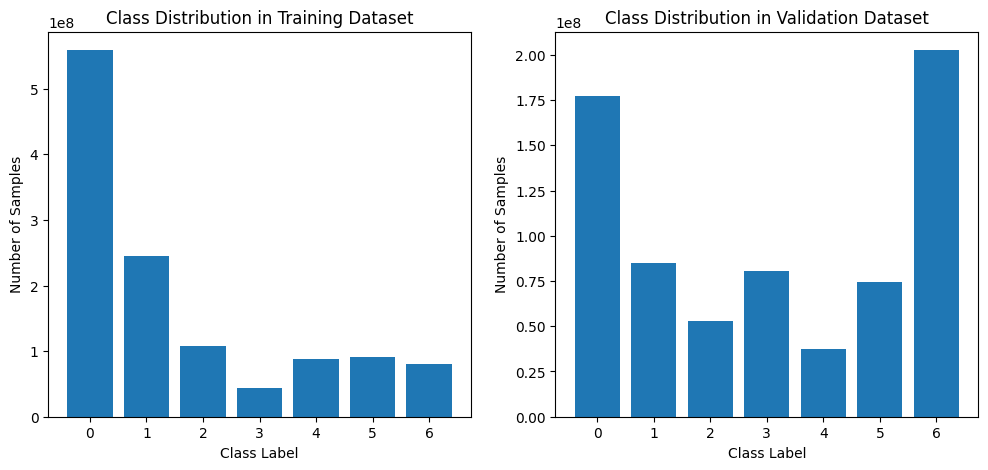

In [5]:
# TODO
import matplotlib.pyplot as plt
def class_distribution(dataset):
  class_count=np.zeros(7)
  for  _, labels in dataset:
    class_id,counts=np.unique(labels,return_counts=True)
    for i in range(len(class_id)):
      class_count[class_id[i]]+=counts[i]
  return class_count


train_count=class_distribution(train_dataset)
val_count=class_distribution(val_dataset)
print(train_count)
print(val_count)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].bar(range(len(train_count)),train_count)
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Number of Samples")
axes[0].set_title("Class Distribution in Training Dataset")

axes[1].bar(range(len(train_count)),val_count)
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Number of Samples")
axes[1].set_title("Class Distribution in Validation Dataset")


plt.show()



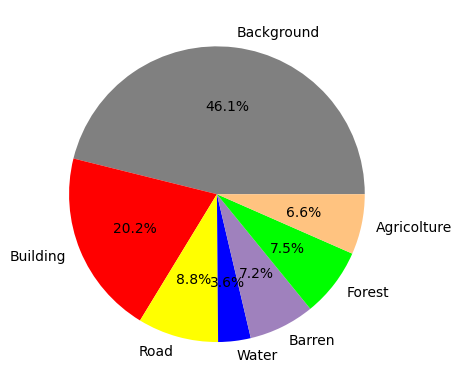

In [38]:

y = train_count
mylabels = ["Background", "Building", "Road", "Water","Barren","Forest","Agricolture"]
mycolors = ["grey","#FF0000" , "#FFFF00", "#0000FF","#9F81BD","#00FF00","#FFC380"]


plt.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%')
plt.show()
plt.show()

In [ ]:
def get_class_percentage(labels,classe):
  labels=torch.from_numpy(labels)
  class_count = torch.sum(labels == classe).item()
  total_labels = labels.nelement()
  percentage = (class_count / total_labels) * 100
  return(percentage)



In [ ]:
import random
import os
import numpy as np
from torchvision.utils import save_image
from PIL import Image
import torch
import torchvision.transforms as transforms

transa = transforms.ToTensor()
hflip_t = transforms.RandomHorizontalFlip(p=1)
vflip = transforms.RandomVerticalFlip(p=1)
added = 0

num_classes = 7

for image, label in train_dataset:

    label = label.astype(np.int64)

    if get_class_percentage(label, 6) > 10:
        if random.randint(0, 1):

            image = hflip_t(image)
            label = hflip_t(torch.from_numpy(label)).numpy()
        else:

            image = vflip(image)
            label = vflip(torch.from_numpy(label)).numpy()


        label = np.clip(label, -1, num_classes)


        save_image(image, f'/content/Train/Urban/images_png/added{added}.png')


        label_path = f'/content/Train/Urban/masks_png/added{added}.png'
        Image.fromarray(label.astype(np.uint8)).save(label_path)
        added += 1

    if get_class_percentage(label, 6) > 30:
      image = hflip_t(image)
      label = hflip_t(torch.from_numpy(label)).numpy()
      label = np.clip(label, -1, num_classes)
      save_image(image, f'/content/Train/Urban/images_png/added{added}.png')
      label_path = f'/content/Train/Urban/masks_png/added{added}.png'
      Image.fromarray(label.astype(np.uint8)).save(label_path)
      added += 1


      image = vflip(image)
      label = vflip(torch.from_numpy(label)).numpy()
      label = np.clip(label, -1, num_classes)


      save_image(image, f'/content/Train/Urban/images_png/added{added}.png')


      label_path = f'/content/Train/Urban/masks_png/added{added}.png'
      Image.fromarray(label.astype(np.uint8)).save(label_path)
      added += 1

index = 0
removed = 0
for (image, label) in val_dataset:
    if get_class_percentage(label, 6) > 70:
        img_path, label_path = val_dataset.__path__(index)
        os.remove(img_path)
        os.remove(label_path)
        removed += 1
    elif get_class_percentage(label, 6) > 50 and random.randint(0, 1):
        img_path, label_path = val_dataset.__path__(index)
        os.remove(img_path)
        os.remove(label_path)
        removed += 1
    index += 1

print(f"Added {added} images")
print(f"Removed {removed} images")






Added 98 images
Removed 91 images


In [ ]:



train_dataset = LoveDA(image_dir = "../content/Train/Urban/images_png", mask_dir = "../content/Train/Urban/masks_png",augment=False)
val_dataset   = LoveDA(image_dir   = "../content/Val/Urban/images_png", mask_dir = "../content/Val/Urban/masks_png",augment=False)


../content/Train/Urban -- Dataset images: 1254
../content/Val/Urban -- Dataset images: 586


Train class distribution:
{0: 570090309, 1: 251802771, 2: 110998877, 4: 94802111, 5: 126505464, 3: 47469187, 6: 21403138, -1: 87618146, 254: 4224301}
Validation class distribution:
{0: 169950420, 1: 82620740, 2: 47617463, 5: 69278448, 6: 108733912, 3: 74118765, 4: 35953686, -1: 26192102}


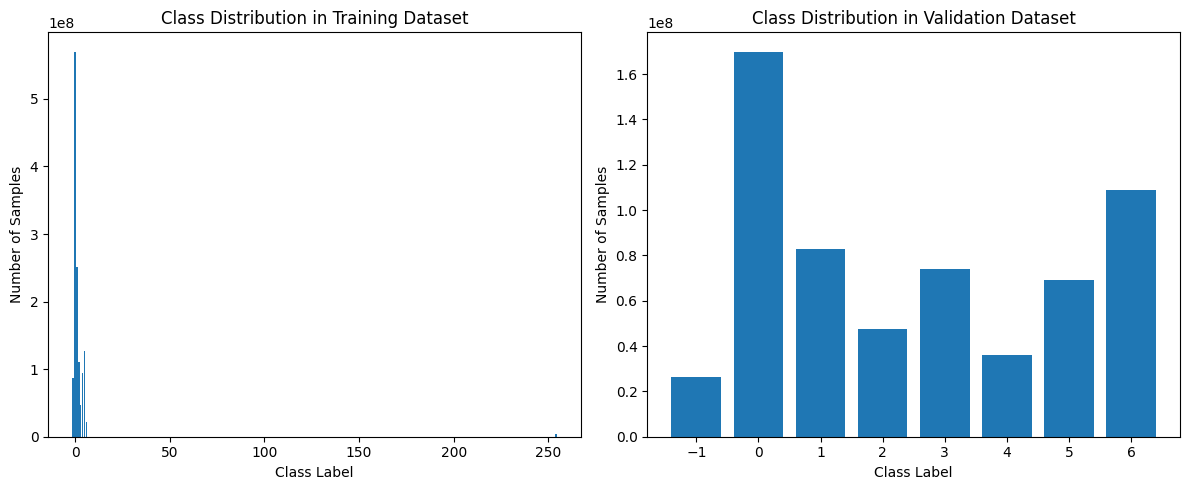

In [ ]:
import matplotlib.pyplot as plt
def class_distribution(dataset):
  count_classes={}
  for i in range(len(dataset)):
    _, labels = dataset[i]

    labels=labels.flatten() #to make it monodimensional
    classes=np.unique(labels) #in this way we extract the classes belonging to the labels analysed
    for classe in classes:
      if classe in count_classes:
        count_classes[classe] += np.count_nonzero(labels==classe)
      else:
        count_classes[classe]=np.count_nonzero(labels==classe)
  return count_classes

train_class_counts = class_distribution(train_dataset)
print("Train class distribution:")
print(train_class_counts)
val_class_counts = class_distribution(val_dataset)
print("Validation class distribution:")
print(val_class_counts)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].bar(train_class_counts.keys(), train_class_counts.values())
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Number of Samples")
axes[0].set_title("Class Distribution in Training Dataset")

axes[1].bar(val_class_counts.keys(), val_class_counts.values())
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Number of Samples")
axes[1].set_title("Class Distribution in Validation Dataset")

plt.tight_layout()
plt.show()

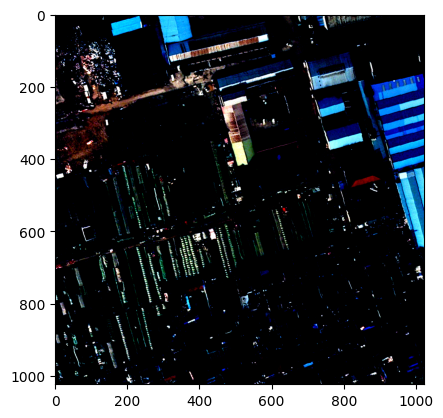

In [ ]:
img = imread("/content/Train/Urban/images_png/added0.png")
plt.imshow(img)


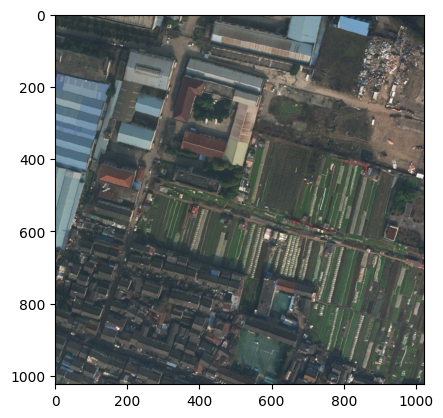

In [ ]:
image,_=train_dataset[0]
show_image(image, transform=invTrans)


**DATALOADER**

Il dataset recupera le caratteristiche e le etichette del nostro dataset un campione alla volta. Durante il training di un modello, vogliamo passare i campioni in “minibatch”, rimescolare i dati a ogni epoca per ridurre l'overfitting del modello e usare il multiprocessing di Python per velocizzare il processo di recupero dei dati.

DataLoader è lo strumento che utilizziamo. In particolare, il DataLoader estrae istanze di dati dal Dataset, le raccoglie in batch e le restituisce per lo svolgimento del training loop. Il DataLoader funziona con tutti i tipi di dataset, indipendentemente dal tipo di dati che contengono.

In [ ]:
dataloader_train = DataLoader(train_dataset,
                              batch_size=16,
                              shuffle=True,     #TODO
                              num_workers=1,
                              pin_memory=False,
                              drop_last=True)

dataloader_val = DataLoader(val_dataset,
                            batch_size=1,
                            shuffle=False,       #TODO
                            num_workers=2,
                            drop_last=False)

## **STEP 2**

Una volta creato il nostro Dataset, costruiamo il modello di segmentazione: BiseNet.


In [ ]:
from MLDL2024_project1.models.bisenet.build_bisenet import BiSeNet
num_classes = 7
model = BiSeNet(num_classes=num_classes, context_path="resnet18")
model = model.cuda()

#per caricare modello
dict_weight = torch.load("best.pth")
model.load_state_dict(dict_weight)

<All keys matched successfully>

Definiamo gli strumenti che ci servieranno a trainare la rete: il numero di epoche, il batch size, il learning rate, l'optimizer e la loss function.

Link utili:


*   [Cross-entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
*   [Optimizers](https://pytorch.org/docs/stable/optim.html)



In [ ]:
num_epochs    = 100  #TODO
learning_rate = 1e-4  #TODO

MOMENTUM = 0.9 #Keep this for SGD
WEIGHT_DECAY = 1e-4  # Regularization, you can keep this at the default
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=learning_rate, weight_decay=WEIGHT_DECAY,momentum=MOMENTUM)
#optimizer     = ...   #TODO

# Define scheduler
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
STEP_SIZE = 110 # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1 # Multiplicative factor for learning rate step-down
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
# scheduler     = ...   #TODO

loss_fn  = torch.nn.CrossEntropyLoss(ignore_index=-1)

settings={"epoche":num_epochs,"learning_rate":learning_rate,"step_size":STEP_SIZE, "batch_size":16,"optimizer":"SGD"}

# **STEP 3**

Nello step 1 e step 2, abbiamo definito tutto il necessario per addestrare la nostra rete di segmentazione: abbiamo creato il **dataset**, costruito il **dataloader**, inizializzato il **modello** e stabilito gli **iperparametri**.

A questo punto, implementiamo il training loop, che è il fulcro del processo di training della rete neurale. Ecco i passi fondamentali che lo compongono:

1. **Impostare la rete in modalità di training**: prima di iniziare il ciclo di addestramento, assicurarsi di impostare il modello in modalità train con model.train().

2. **Iterare sui dati**: utilizzando il dataloader, dovrete iterare su ciascun batch del dataset. Per ogni batch, eseguite i seguenti passaggi:

* **Input e target**: ottenere gli input (le immagini) e i target (le etichette) dal batch.

* **Forward pass**: passare gli input attraverso il modello per ottenere le prediction (output del modello).

* **Calcolo della loss**: confrontare le prediction con i target utilizzando la funzione di loss definita (ad esempio, cross-entropy loss per la segmentazione).

3. **Backpropagation**:

* **Zero gradients**: azzerare i gradienti accumulati in ogni iterazione con optimizer.zero_grad().

* **Loss backward**: eseguire la backpropagation della loss con loss.backward() per calcolare i gradienti rispetto ai pesi del modello.

* **Ottimizzazione**: aggiornare i pesi del modello utilizzando l'optimizer con optimizer.step(). Questo permette di minimizzare la loss.

Logging e validazione (opzionale): durante il training, potete monitorare l'andamento della loss e altre metriche per tenere traccia dei progressi. E' utile eseguire un'operazione di validation su un set di dati separato a intervalli regolari per monitorare il comportamento del modello.

Ripetete questo ciclo per un numero predefinito di epoch.

In [ ]:
def train(model, dataloader, loss_fn, optimizer):
    """
    Funzione per eseguire il ciclo di training del modello su un dataset.

    Parametri:
    - model: la rete neurale da addestrare.
    - dataloader: il DataLoader che fornisce i bacat tch di dati per il training.
    - loss_fn: la loss function per calcolare l'errore tra le predizioni e i target.
    - optimizer: l'optimizer utilizzato per aggiornare i pesi del modello.

    La funzione itera sui batch di dati, esegue la forward pass, calcola la loss, applica la backpropagation per aggiornare i pesi del modello e ritorna la loss media per l'epoch.
    """
    tq = tqdm(total=len(dataloader_train) * batch_size, ncols=100, leave=True, position=0)
    tq.set_description('epoch %d' % (epoch))
    loss_record = []
    for step, (data, label) in enumerate(dataloader_train):
      data = data.cuda()
      label = label.long().cuda()
      optimizer.zero_grad()

      with amp.autocast():
          output, out16, out32 = model(data)
          loss1 = loss_fn(output, label.squeeze(1))
          loss2 = loss_fn(out16, label.squeeze(1))
          loss3 = loss_fn(out32, label.squeeze(1))
          loss = loss1 + loss2 + loss3

      loss.backward()
      optimizer.step()
      tq.update(batch_size)
      tq.set_postfix(loss='%.6f' % loss)
      loss_record.append(loss.item())
    tq.close()
    loss_train_mean = np.mean(loss_record)
    return loss_train_mean


In [ ]:
from MLDL2024_project1.utils import fast_hist, per_class_iou

def val(model, dataloader):
    """
    Funzione per eseguire la validazione del modello su un dataset di validazione.

    Parametri:
    - model: la rete neurale da validare.
    - dataloader: il DataLoader che fornisce i batch di dati per la validazione.

    La funzione imposta il modello in modalità evaluation (model.eval()), disabilita il calcolo dei gradienti, esegue la forward pass per ottenere le predizioni e calcola la mIoU.
    """
    print('start validation!')
    with torch.no_grad():
        model.eval()
        precision_record = []
        hist = np.zeros((num_classes, num_classes))
        for i, (data, label) in tqdm(enumerate(dataloader), total=len(dataloader), ncols=100, leave=True, position=0):
            label = label.type(torch.LongTensor)
            data = data.cuda()
            label = label.long().cuda()

            # get RGB predict image
            predict = model(data)
            predict = predict[0].squeeze(0)
            predict = predict.permute(1, 2, 0)
            predict = torch.argmax(predict, dim=-1)
            predict = np.array(predict.cpu())

            # get RGB label image
            label = label.squeeze()
            label = np.array(label.cpu())

            # compute per pixel accuracy
            hist += fast_hist(label.flatten(), predict.flatten(), num_classes)

        miou_list = per_class_iou(hist)
        miou = np.mean(miou_list)
        print('mIoU for validation: %.3f' % miou)
        print(f'mIoU per class: {miou_list}')

        return miou, miou_list

In [ ]:
#miou,listona=val(model,dataloader_val)

In [ ]:
def loss_plot(saves,class_saving):
  train_losses = [save['loss'] for save in saves]
  mIoUs = [save['miou'] for save in saves]
  fig, axes = plt.subplots(3, 1, figsize=(20, 30))

  axes[0].plot(train_losses, 'o-')
  axes[0].set_title('Train Loss Trend')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].grid(True)

  axes[1].plot(mIoUs, 'o-')
  axes[1].set_title('mIoU Trend')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('mIoU')
  axes[1].grid(True)

  class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']

  result = {}

  for d in class_saving:
    for key, value in d.items():
       if key not in result:
        result[key] = []
       result[key].append(value)

  for key in result:
    axes[2].plot(result[key],'o-')
  axes[2].set_title('Miou per class')
  axes[2].set_xlabel('Epoch')
  axes[2].set_ylabel('Miou')
  axes[2].grid(True)
  axes[2].legend(class_names)

  plt.savefig("log.png")
  plt.show()
  return result

In [ ]:
from google.colab import drive
import shutil
import json
drive.mount('/content/drive')
def save_to_drive(settings,saves,class_saving):



  path = "/content/drive/My Drive/Colab Notebooks/logs"

  if not os.path.exists(path):
    os.mkdir(path)

  json.dump(settings, open(path+"/settings.txt",'w')) #scrivi dizionario

  result=loss_plot(saves,class_saving)
  #json.load(open(path+"/log.txt")) #carica dizionario
  shutil.copy("best_model/best.pth", path+"/best.pth") #save best model
  shutil.copy("log.png", path+"/log.png") #save graphs

  json.dump(result, open(path+"/miou_per_class.txt",'w'))




Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
batch_size=16

writer = SummaryWriter(log_dir='logs')

max_miou = -1
save_model_path = "./best_model"

saves=[]
class_saves=[]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    # Fase di training
    model.train()  # Imposta il modello in modalità training
    train_loss = train(model, dataloader_train, loss_fn, optimizer)
    writer.add_scalar('epoch/loss_epoch_train', float(train_loss), epoch)
    # Fase di validazione
    model.eval()  # Imposta il modello in modalità evaluation
    with torch.no_grad():  # Disabilita il calcolo dei gradienti durante la validazione
        mIoU,class_miou = val(model, dataloader_val)
    if mIoU > max_miou:
      print("Save best model! Epoch: ", epoch)
      max_miou = mIoU
      import os
      os.makedirs(save_model_path, exist_ok=True)
      torch.save(model.state_dict(), os.path.join(save_model_path, 'best.pth'))

    saving={"loss":train_loss,"miou":mIoU}
    class_saving={0:class_miou[0],1:class_miou[1],2:class_miou[2],3:class_miou[3],4:class_miou[4],5:class_miou[5],6:class_miou[6]}

    saves.append(saving)

    class_saves.append(class_saving)

    #loss_plot(saves,class_saves) #if you want only to plot
    save_to_drive(settings,saves,class_saves) #if you want to plot and save in the drive





Al termine del training, vi chiediamo di visualizzare il **trend della loss** durante le varie epoche per monitorare l'andamento del training.
Inoltre, dovrete visualizzare anche le performance del modello attraverso l'andamento della **metrica mIoU** (mean Intersection over Union), a livello globale e per singola classe.

In [ ]:
#TODO

with open("log.txt","w") as file:
  file.write(f"Epoche:\t\t\t{30}\nLearning rate:\t\t\t{learning_rate}\nStep_Size:\t\t\t{STEP_SIZE}\nGamma:\t\t\t{GAMMA}\nBatch Size:\t\t\t{batch_size}\nWeigth Decay:\t\t\t{WEIGHT_DECAY}\nOptimizer:\t\t\t{(str(optimizer)[0:5])}")

loss_plot(saves)

TypeError: loss_plot() missing 1 required positional argument: 'class_saving'

# **STEP 4**

**PREDIZIONI DEL MODELLO**

Una volta completato il training e valutate le performance numericamente, è importante anche effettuare una **valutazione qualitativa** delle performance del modello. Questo ci permette di vedere visivamente come la rete si comporta su immagini reali del validation set, confrontando le predizioni del modello con le label semantiche.

**Cosa dovete fare**:
1. Ottenere le immagini dal validation set: Prelevate un sample di immagini dal validation set.
2. Generare le predizioni del modello: Utilizzate il modello addestrato per effettuare le predizioni su queste immagini.
3. Visualizzare i risultati: Per ogni immagine del validation set:
* Mostrate l'immagine originale.
* Visualizzate la predizione della rete neurale (segmentazione predetta).
* Visualizzate l'etichetta reale (semantic label) corrispondente.

Commentare queste visualizzazioni in funzione dei risultati numerici ottenuti.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

def show_image_with_label_and_prediction(img, label, prediction, transform=None):
    """
    Mostra un'immagine, il relativo label e la predizione di un modello in un unico subplot.

    Args:
        img: L'immagine da visualizzare.
        label: Il label associato all'immagine.
        prediction: La predizione del modello per l'immagine.
        transform: Una trasformazione da applicare all'immagine (opzionale).
        one_channel: Se True, converte l'immagine in scala di grigi (opzionale).
    """
    # Trasformazione opzionale sull'immagine
    if transform:
        img = transform(img)

    # Converte l'immagine in un array numpy
    npimg = img.numpy()

    # Gestisce il caso di un'immagine in un singolo canale

    npimg = np.transpose(npimg, (1, 2, 0))
    cmap = None

    # Trasforma il label e la predizione in immagini colorate
    np_label = colour_code_segmentation(label)
    np_label = np_label.astype(int)

    np_prediction = colour_code_segmentation(prediction)
    np_prediction = np_prediction.astype(int)

    # Crea i subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Mostra l'immagine
    axs[0].imshow(npimg, cmap=cmap)
    axs[0].axis("off")
    axs[0].set_title("Image")

    # Mostra il label
    axs[1].imshow(np_label)
    axs[1].axis("off")
    axs[1].set_title("Label")

    # Mostra la predizione
    axs[2].imshow(np_prediction)
    axs[2].axis("off")
    axs[2].set_title("Prediction")

    # Mostra il tutto
    plt.tight_layout()
    plt.show()




In [ ]:
def show_image(img, transform=None, one_channel=False):
    img = transform(img)
    npimg = img.numpy()
    npimp=(np.transpose(npimg, (1, 2, 0)))
    return npimp

def show_label(img):
    npimg = colour_code_segmentation(img)
    npimg = npimg.astype(int)
    return npimg

In [ ]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

# Correggo il codice

dataiter = iter(val_dataset)

# Imposta il modello in evaluation mode
with torch.no_grad():
    model.eval()
    for ((data, label), label2) in zip(tqdm((dataloader_val), total=len(dataloader_val), ncols=100, leave=True, position=0),dataiter):
        # Assicurati che i tensori siano del tipo corretto
        label = label.type(torch.LongTensor)
        data = data.cuda()
        label = label.long().cuda()

        # Ottieni la predizione dal modello
        predict = model(data)
        predict = predict[0].squeeze(0).permute(1, 2, 0)
        predict = torch.argmax(predict, dim=-1).cpu().numpy()

        # Converti il label in formato numpy
        label_np = label.squeeze().cpu().numpy()

        # Mostra l'immagine originale
        image_np = show_image(data[0].cpu(), transform=invTrans)

        # Crea i subplots per Input Image, Label e Prediction
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Input Image
        axes[0].imshow(image_np)
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        # Label
        label_visual = show_label(label_np)
        axes[1].imshow(label_visual)
        axes[1].set_title("Label")
        axes[1].axis("off")

        # Prediction
        predict_visual = show_label(predict)
        axes[2].imshow(predict_visual)
        axes[2].set_title("Prediction")
        axes[2].axis("off")

        # Mostra il plot
        plt.tight_layout()
        plt.show()


In [ ]:
print(image_np)

None


In [ ]:
"""data = []
with torch.no_grad():
  model.eval()
  for i in range(0, 16):
    img, labels = next(dataiter)
    images = img.cuda() #da testare
    predict = model(images) #da testare
    data.append([img, labels, predict])



def show_images_label(data, transform = None):
    for index, element in enumerate(data):
      plt.figure(index + 1)
      img, labels, predicted = element
      # print img
      img = transform(img)
      npimg = img.numpy()
      plt.subplot(1,3, 1)
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      # print labels
      npimg = colour_code_segmentation(labels)
      npimg = npimg.astype(int)
      plt.subplot(1, 3, 2)
      plt.imshow(npimg)
      # print predicted
      npimg = colour_code_segmentation(predicted)
      npimg = npimg.astype(int)
      plt.subplot(1, 3, 3)
      plt.imshow(npimg)

show_images_label(data, invTrans)



dataiter = iter(val_dataset)
images, labels = next(dataiter)
images, labels = next(dataiter)
show_image(images, transform=invTrans)""" #giulio




for (i, (data, label)), in tqdm(enumerate(dataloader_val), total=len(dataloader_val), ncols=100, leave=True, position=0):
  label = label.type(torch.LongTensor)
  data = data.cuda()
  label = label.long().cuda()

  # get RGB predict image
  predict = model(data)
  predict = predict[0].squeeze(0)
  predict = predict.permute(1, 2, 0)
  predict = torch.argmax(predict, dim=-1)
  predict = np.array(predict.cpu())

  # get RGB label image
  label = label.squeeze()
  label = np.array(label.cpu())





def show_images_label(data, transform = None):
    for index, element in enumerate(data):
      plt.figure(index + 1)
      img, labels, predicted = element
      # print img
      img = transform(img)
      npimg = img.numpy()
      plt.subplot(1,3, 1)
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      # print labels
      npimg = colour_code_segmentation(labels)
      npimg = npimg.astype(int)
      plt.subplot(1, 3, 2)
      plt.imshow(npimg)
      # print predicted
      npimg = colour_code_segmentation(predicted)
      npimg = npimg.astype(int)
      plt.subplot(1, 3, 3)
      plt.imshow(npimg)

show_images_label(data, invTrans)



dataiter = iter(val_dataset)
images, labels = next(dataiter)
images, labels = next(dataiter)
show_image(images, transform=invTrans)


"""with torch.no_grad():
  model.eval()
  precision_record = []
  for i, (data, label) in tqdm(enumerate(dataloader_val), total=len(dataloader_val), ncols=100, leave=True, position=0):
      label = label.type(torch.LongTensor)
      data = data.cuda()
      label = label.long().cuda()

      # get RGB predict image
      predict = model(data)
      predict = predict[0].squeeze(0)
      predict = predict.permute(1, 2, 0)
      predict = torch.argmax(predict, dim=-1)
      predict = np.array(predict.cpu())

      # get RGB label image
      label = label.squeeze()
      label = np.array(label.cpu())

      plt.imshow(predict)
      plt.title(f"Predicted Image {i}")
      plt.show()"""

  0%|                                                                       | 0/677 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 1)

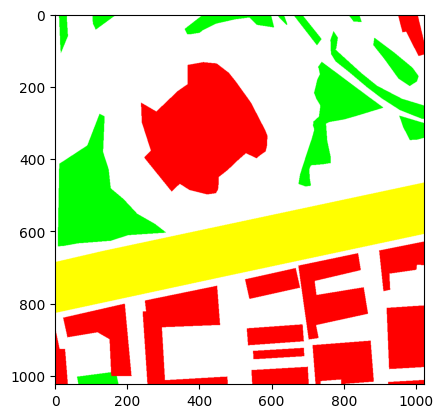

In [ ]:
show_label(labels)

In [ ]:
with torch.no_grad():
  model.eval()
  images = images.cuda()
  predict = model(images)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# **STEP 5**

**RICERCA DEGLI HYPERPARAMETERS**

L’ottimizzazione degli hyperparameter è una parte fondamentale del training dei modelli di deep learning. Modificare questi parametri può influenzare significativamente le performance del modello, sia globalmente (ad esempio, in termini di mIoU) sia localmente (ad esempio, sulla IoU di specifiche classi).

**Cosa dovete fare**:

**Sperimentate con uno o più dei seguenti parametri**:


1.   Batch size
2.   Learning rate
3.   Optimizer
4. Numero di epoche

Cambiate uno o più hyperparameter e riaddestrate il modello. Per ogni configurazione i) annotate i valori degli hyperparameter scelti e ii) eseguite il training e valutate le performance sul validation set. Analizzate come le modifiche degli hyperparameter influenzano la convergenza del modello durante il training e le performance globali e per classe.


In [ ]:
#TODO

In [ ]:
#DATA AUG

In [ ]:
def get_class_percentage(labels,classe):
  labels=torch.from_numpy(labels)
  class_count = torch.sum(labels == classe).item()
  total_labels = labels.nelement()
  percentage = (class_count / total_labels) * 100
  return(percentage)

In [ ]:
import torchvision.transforms as transforms

hflip_t = transforms.RandomHorizontalFlip(p=1)
vflip = transforms.RandomVerticalFlip(p=1)

In [ ]:
training=[]
validation=[]
added=0
removed=0
for image,label in train_dataset:
  LABELLO=label
  if get_class_percentage(label, 6) > 30:
    image = hflip_t(image)
    label = hflip_t(torch.from_numpy(label)).numpy()
    added += 1
    training.append((image,label))

  if get_class_percentage(LABELLO, 6) > 10:
      if random.random()<0.5:
        if random.randint(0,1):
          image = hflip_t(image)
          LABELLO = hflip_t(torch.from_numpy(label)).numpy()
          training.append((image,LABELLO))
          added+=1
        else:
          image = vflip(image)
          LABELLO = vflip(torch.from_numpy(label)).numpy()
          training.append((image,LABELLO))
          added+=1
  training.append((image,label))



for (images, labels) in val_dataset:
    if get_class_percentage(label, 6) > 50:
        training.append((images,labels))
        removed += 1
    elif get_class_percentage(label, 6) > 40 and random.randint(0, 1):
        training.append((images,labels))
        removed += 1
    else:
        validation.append((images,labels))

print(f"Added {added} images")
print(f"Removed {removed} images")




In [ ]:
# TODO
import matplotlib.pyplot as plt
def class_distribution(dataset):
  count_classes={}
  for i in range(len(dataset)):
    _, labels = dataset[i]

    labels=labels.flatten() #to make it monodimensional
    classes=np.unique(labels) #in this way we extract the classes belonging to the labels analysed
    for classe in classes:
      if classe in count_classes:
        count_classes[classe] += np.count_nonzero(labels==classe)
      else:
        count_classes[classe]=np.count_nonzero(labels==classe)
  return count_classes




train_class_counts = class_distribution(training)
print("Train class distribution:")
print(train_class_counts)
val_class_counts = class_distribution(validation)
print("Validation class distribution:")
print(val_class_counts)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].bar(train_class_counts.keys(), train_class_counts.values())
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Number of Samples")
axes[0].set_title("Class Distribution in Training Dataset")

axes[1].bar(val_class_counts.keys(), val_class_counts.values())
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Number of Samples")
axes[1].set_title("Class Distribution in Validation Dataset")

plt.tight_layout()
plt.show()


total_class_counts={}
for i in train_class_counts.keys():
  total_class_counts[i]=train_class_counts[i]+val_class_counts[i]

print("Total class distribution:")
print(total_class_counts)
plt.bar(total_class_counts.keys(), total_class_counts.values())
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Total classes distribution")
plt.show()


NameError: name 'training' is not defined